# DQN training on our own gridworld

In [ ]:
! pip install gym tqdm torchvision

## Importing necessary libraries

In [20]:
import numpy as np
import pandas as pd

import time
import gym

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm import tqdm
import random

import torch.nn.functional as F
import torch 
from torch import nn
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image
from collections import deque

import time

## Importing the custom environment

In [21]:
from mario2 import MyMarioEnvironment2

## DQN network with fully connected layers

In [22]:
class DQN_FC(nn.Module):
    def __init__(self, i, o):
        super(DQN_FC, self).__init__()
        self.fc1 = nn.Linear(in_features=i, out_features=8)
        self.fc2 = nn.Linear(in_features=8, out_features=8)
        self.fc3 = nn.Linear(in_features=8, out_features=o)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x    

## DQN network with convolutional layers

Not used for solving the custom grid environment. Present for future use.

In [23]:
class DQN_CNN(nn.Module):
    def __init__(self, h, w, o):
        super(DQN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=4, stride=2)
        # print(self.conv_output_shape(h,8,4,0,1))
        out_conv_h = self.conv_output_shape(self.conv_output_shape(h,8,4,0,1),4,2,0,1)
        out_conv_w = self.conv_output_shape(self.conv_output_shape(w,8,4,0,1),4,2,0,1)
        self.fc = nn.Linear(in_features=out_conv_h*out_conv_w*32, out_features=o)
        # print(h,w, out_conv_h,out_conv_w)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.relu(self.conv1(x))
        # print("c1",x.shape)
        x = self.relu(self.conv2(x))
        # print("c2",x.shape)
        x = self.sigmoid(self.fc(self.flatten(x)))
        return x
    
    def conv_output_shape(self, size, kernel_size=1, stride=1, pad=0, dilation=1):
        from math import floor
        if type(kernel_size) is not tuple:
            kernel_size = (kernel_size, kernel_size)
        out = floor( ((size + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )// stride) + 1)
        return out

DDQN

In [24]:
class GridDoubleDQN():
    def __init__(self, env, typ="dense",gamma=0.90, lr=0.001):
      self.env = env
      self.typ = typ
      self.max_episodes = 2500
      self.max_steps = 30
      self.gamma = gamma
      self.epsilon = 1.0
      self.epsilon_min = 0.01
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 50
      self.replay_buffer_capacity=4000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
#       _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      obs,aud = self.env.reset()
      obs.extend(self.env.reset()[1])
      lenn = len(obs)
      self.state_count = env.observation_space.n
      self.action_count = env.action_space.n
      self.target_dqn = DQN_FC(lenn, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      self.q_value_dqn = DQN_FC(lenn, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.rms_optimizer = optim.SGD(self.q_value_dqn.parameters(), lr=lr)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.loss_func = F.mse_loss #F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.q_value_dqn#.to(self.device)
      self.target_dqn#.to(self.device)

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./grid.pth"

    def initialize_buffer(self):
      for i in range(self.replay_buffer_capacity):
#         current_state = np.where(self.env.reset() == 1)
#         current_state = 
        done = False
        while not done:  
            current_action = self.choose_action(torch.as_tensor(current_state, dtype=torch.float))#.to(self.device)
            next_state, curr_reward, done, truncated, info = self.env.step(current_action)
#           next_state = self.screen_preprocessor(self.env.render())

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            current_state = next_state

    def screen_preprocessor(self,state_screen):
      def crop(variable,tw,th):
         c, h, w = variable.shape
         x1 = int(round((w - tw) / 2.))
         y1 = int(round((h - th) / 2.))
         return variable[:,y1:y1+th,x1:x1+tw]
      state_screen = state_screen.transpose((2,0,1))
      screen_c, screen_h, screen_w = state_screen.shape
      screen = self.resize(torch.from_numpy(state_screen))
      screen = crop(screen, 60, 60)
      screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
      screen = torch.from_numpy(screen)
      return screen.unsqueeze(0)
    
    def choose_action(self, state, test=False):
      random_no = np.random.random()
      if self.epsilon > random_no and not test:
          return np.random.choice(self.env.action_space.n)
      else:
          return torch.argmax(self.q_value_dqn(state)).item()#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.q_value_dqn(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self,load=False, max_ep=10):
      if load:
        self.q_value_dqn.load_state_dict(torch.load(self.trained_policy_path))

      self.test_max_episodes = max_ep
      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs,aud = self.env.reset()
        obs.extend(aud)
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
          tt = time.time()

          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs,curr_aud, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
          curr_obs.extend(curr_aud)
          curr_obs = torch.tensor(curr_obs,dtype=torch.float)
          
          # self.env.render(mode="rgb", save=False, step=steps)

          reward_sum += curr_reward
          next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

          steps +=1
          
          current_state = next_state
          if steps==20 or reward_sum==16:
            done=True
            
        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self):
      current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch = self.get_minibatch_from_replay_buffer()
#       print(current_state_batch)
      curr_q_value_list = self.q_value_dqn(current_state_batch).gather(1, current_action_batch.reshape([self.buffer_minibatch_size,1])) #.to(self.device)).gather(1, current_action_batch)
#       next_q_value_list = self.target_dqn(next_state_batch)#.to(self.device))

      next_q_value_list = self.target_dqn(next_state_batch)
    
      with torch.no_grad():
          best_actions = torch.argmax(self.q_value_dqn(next_state_batch), dim=1)

      next_q_value_list = next_q_value_list.gather(1, best_actions.reshape([self.buffer_minibatch_size, 1]))
      next_q_value_list = next_q_value_list.detach()
      exp_q_value_list = []
      for index in range(self.buffer_minibatch_size):
        # if current_done_batch[index]:
        #   exp_q_value_list.append(current_reward_batch[index])
        # else:
          exp_q_value_list.append((current_reward_batch[index] + next_q_value_list[index] * self.gamma))

      exp_q_value_list = torch.tensor(exp_q_value_list).unsqueeze(1)#.to(self.device)

      self.rms_optimizer.zero_grad()
      loss = self.loss_func(curr_q_value_list, exp_q_value_list)
      loss.backward()
      for param in self.q_value_dqn.parameters():
          param.grad.data.clamp_(-1, 1)
      self.rms_optimizer.step()

      return 0#loss.item()
      
    def learn(self):
      self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
      self.target_dqn.eval()
      
      running_loss=0
      loss=0
      self.tm = []
      self.tr = []
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        # with Profiler() as p:
        obs,aud_obs = self.env.reset()
        obs.extend(aud_obs)
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
            tt = time.time()

            current_action = self.choose_action(current_state)#.to(self.device)
            curr_obs, curr_audio, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
            curr_obs.extend(curr_audio)
            curr_obs = torch.tensor(curr_obs, dtype=torch.float)
#             print(current_state, current_action, curr_obs, curr_reward, done)

            reward_sum += curr_reward

            next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            t = time.time() 

            if len(self.replay_buffer) >= self.buffer_minibatch_size:       
                loss = self.train()
            self.tm.append(time.time()-t)
            steps +=1
            running_loss = loss*self.buffer_minibatch_size
            current_state = next_state

            self.tr.append(time.time()-tt)
            if steps==self.max_steps or reward_sum==16:
                done=True

        self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda) #if episode>500 else self.epsilon
      
        if episode % 100 == 99:
          print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          # print(f'[Episode: {episode+1}] - Steps: {steps+1} | Rewards: {reward_sum+1} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          running_loss = 0.0
          # p.print()
        
    def update_target_net(self, episode):
       tao = 0.7
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
#           self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
          q_value_dict = self.q_value_dqn.state_dict()
          target_dict = self.target_dqn.state_dict()
          for pred_param, target_param in zip(q_value_dict.items(), target_dict.items()):
              new_param = tao * pred_param[1] + (1-tao)*target_param[1]
              target_param[1].copy_(new_param)
              
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size) #max(len(self.replay_buffer), self.buffer_minibatch_size))
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
#       current_action_batch = torch.cat(tuple([exp[1] for exp in exp_batch]),dim=0)
      current_action_batch = torch.as_tensor([exp[1] for exp in exp_batch])
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)

In [25]:
env = MyMarioEnvironment2(environment_type = 'deterministic')

a = GridDoubleDQN(env, gamma=0.999, lr=0.001)
a.learn()
rewardSD_g1 = a.rewards_list

env = MyMarioEnvironment2(environment_type = 'deterministic')
a = GridDoubleDQN(env, gamma=0.990, lr=0.001)
a.learn()
rewardSD_g2 = a.rewards_list

env = MyMarioEnvironment2(environment_type = 'deterministic')
a = GridDoubleDQN(env, gamma=0.90, lr=0.001)
a.learn()
rewardSD_g3 = a.rewards_list

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
  4%|▍         | 101/2500 [00:11<04:22,  9.14episodes/s]

Buffer_size: 2953|Train_time:0.0031056833267211915| Sub_t:0.0035292840003967284
[Episode: 100] - Steps: 29.53 | Rewards: -6.06 | Epsilon: 0.8317637711026726 | loss: 0.000


  8%|▊         | 202/2500 [00:24<03:55,  9.75episodes/s]

Buffer_size: 4000|Train_time:0.0030704140663146973| Sub_t:0.003534133434295654
[Episode: 200] - Steps: 29.79 | Rewards: -5.26 | Epsilon: 0.691830970918939 | loss: 0.000


 12%|█▏        | 301/2500 [00:36<03:34, 10.23episodes/s]

Buffer_size: 4000|Train_time:0.0029546451568603516| Sub_t:0.0034694647789001464
[Episode: 300] - Steps: 30.0 | Rewards: -4.62 | Epsilon: 0.5754399373371608 | loss: 0.000


 16%|█▌        | 401/2500 [00:48<06:36,  5.29episodes/s]

Buffer_size: 4000|Train_time:0.0038998746871948243| Sub_t:0.004505968093872071
[Episode: 400] - Steps: 30.0 | Rewards: -1.78 | Epsilon: 0.47863009232264275 | loss: 0.000


 20%|██        | 500/2500 [01:12<04:35,  7.26episodes/s]

Buffer_size: 4000|Train_time:0.0034681844711303713| Sub_t:0.0041624665260314945
[Episode: 500] - Steps: 30.0 | Rewards: -0.64 | Epsilon: 0.3981071705535017 | loss: 0.000


 24%|██▍       | 601/2500 [01:29<04:06,  7.71episodes/s]

Buffer_size: 4000|Train_time:0.003726959228515625| Sub_t:0.004546854496002197
[Episode: 600] - Steps: 30.0 | Rewards: -0.64 | Epsilon: 0.3311311214825956 | loss: 0.000


 28%|██▊       | 701/2500 [01:44<03:28,  8.62episodes/s]

Buffer_size: 4000|Train_time:0.0030131149291992188| Sub_t:0.0036259222030639647
[Episode: 700] - Steps: 30.0 | Rewards: -1.05 | Epsilon: 0.27542287033382085 | loss: 0.000


 32%|███▏      | 801/2500 [01:57<03:22,  8.37episodes/s]

Buffer_size: 4000|Train_time:0.003276808261871338| Sub_t:0.003966152667999268
[Episode: 800] - Steps: 30.0 | Rewards: -0.39 | Epsilon: 0.22908676527678132 | loss: 0.000


 36%|███▌      | 901/2500 [02:10<04:05,  6.51episodes/s]

Buffer_size: 4000|Train_time:0.004521112442016601| Sub_t:0.00530750036239624
[Episode: 900] - Steps: 30.0 | Rewards: -0.18 | Epsilon: 0.19054607179632832 | loss: 0.000


 40%|████      | 1001/2500 [02:23<03:25,  7.29episodes/s]

Buffer_size: 4000|Train_time:0.003103444576263428| Sub_t:0.0037645697593688965
[Episode: 1000] - Steps: 30.0 | Rewards: -0.29 | Epsilon: 0.15848931924611465 | loss: 0.000


 44%|████▍     | 1101/2500 [02:36<02:40,  8.70episodes/s]

Buffer_size: 4000|Train_time:0.003013029098510742| Sub_t:0.003668196201324463
[Episode: 1100] - Steps: 30.0 | Rewards: -0.38 | Epsilon: 0.13182567385564378 | loss: 0.000


 48%|████▊     | 1201/2500 [02:48<02:35,  8.36episodes/s]

Buffer_size: 4000|Train_time:0.003235034942626953| Sub_t:0.0038779544830322265
[Episode: 1200] - Steps: 30.0 | Rewards: -0.21 | Epsilon: 0.10964781961432139 | loss: 0.000


 52%|█████▏    | 1301/2500 [03:01<02:49,  7.06episodes/s]

Buffer_size: 4000|Train_time:0.003640623092651367| Sub_t:0.004387335777282715
[Episode: 1300] - Steps: 30.0 | Rewards: -0.23 | Epsilon: 0.09120108393559365 | loss: 0.000


 56%|█████▌    | 1401/2500 [03:11<01:31, 12.02episodes/s]

Buffer_size: 4000|Train_time:0.0023857688903808592| Sub_t:0.0028472089767456053
[Episode: 1400] - Steps: 30.0 | Rewards: -0.09 | Epsilon: 0.07585775750292077 | loss: 0.000


 60%|██████    | 1501/2500 [03:20<01:22, 12.09episodes/s]

Buffer_size: 4000|Train_time:0.0023911571502685546| Sub_t:0.0028661274909973144
[Episode: 1500] - Steps: 30.0 | Rewards: -0.09 | Epsilon: 0.06309573444802141 | loss: 0.000


 64%|██████▍   | 1601/2500 [03:28<01:46,  8.42episodes/s]

Buffer_size: 4000|Train_time:0.002873709201812744| Sub_t:0.00432783842086792
[Episode: 1600] - Steps: 30.0 | Rewards: 0.0 | Epsilon: 0.052480746024979104 | loss: 0.000


 68%|██████▊   | 1701/2500 [03:36<01:04, 12.48episodes/s]

Buffer_size: 4000|Train_time:0.002191004753112793| Sub_t:0.002610921859741211
[Episode: 1700] - Steps: 30.0 | Rewards: -0.02 | Epsilon: 0.043651583224018214 | loss: 0.000


 72%|███████▏  | 1801/2500 [03:45<00:56, 12.43episodes/s]

Buffer_size: 4000|Train_time:0.0022187280654907228| Sub_t:0.0026645565032958982
[Episode: 1800] - Steps: 30.0 | Rewards: -0.08 | Epsilon: 0.03630780547701154 | loss: 0.000


 76%|███████▌  | 1901/2500 [04:02<01:17,  7.74episodes/s]

Buffer_size: 4000|Train_time:0.0031408405303955077| Sub_t:0.003809182643890381
[Episode: 1900] - Steps: 30.0 | Rewards: 0.0 | Epsilon: 0.030199517204021385 | loss: 0.000


 80%|████████  | 2001/2500 [04:14<01:01,  8.10episodes/s]

Buffer_size: 4000|Train_time:0.0036498260498046874| Sub_t:0.004378104209899902
[Episode: 2000] - Steps: 30.0 | Rewards: 0.0 | Epsilon: 0.025118864315096866 | loss: 0.000


 84%|████████▍ | 2102/2500 [04:24<00:37, 10.49episodes/s]

Buffer_size: 4000|Train_time:0.0025274276733398436| Sub_t:0.0030632495880126955
[Episode: 2100] - Steps: 30.0 | Rewards: -0.03 | Epsilon: 0.02089296130854132 | loss: 0.000


 88%|████████▊ | 2201/2500 [04:35<00:40,  7.42episodes/s]

Buffer_size: 4000|Train_time:0.004100022315979004| Sub_t:0.0046721243858337405
[Episode: 2200] - Steps: 30.0 | Rewards: 0.0 | Epsilon: 0.017378008287494567 | loss: 0.000


 92%|█████████▏| 2301/2500 [04:45<00:18, 10.89episodes/s]

Buffer_size: 4000|Train_time:0.002501280307769775| Sub_t:0.003018200397491455
[Episode: 2300] - Steps: 30.0 | Rewards: 0.0 | Epsilon: 0.014454397707459973 | loss: 0.000


 96%|█████████▌| 2401/2500 [04:55<00:09, 10.73episodes/s]

Buffer_size: 4000|Train_time:0.0025922226905822753| Sub_t:0.0030751705169677736
[Episode: 2400] - Steps: 30.0 | Rewards: -0.03 | Epsilon: 0.012022644346174735 | loss: 0.000


100%|██████████| 2500/2500 [05:06<00:00,  8.17episodes/s]


Buffer_size: 4000|Train_time:0.0039040589332580565| Sub_t:0.004531800746917725
[Episode: 2500] - Steps: 30.0 | Rewards: 0.0 | Epsilon: 0.01000000000000053 | loss: 0.000


  4%|▍         | 101/2500 [00:08<03:29, 11.45episodes/s]

Buffer_size: 2979|Train_time:0.002542293071746826| Sub_t:0.002917928695678711
[Episode: 100] - Steps: 29.79 | Rewards: -6.51 | Epsilon: 0.8317637711026726 | loss: 0.000


  8%|▊         | 201/2500 [00:18<03:18, 11.60episodes/s]

Buffer_size: 4000|Train_time:0.0025383591651916503| Sub_t:0.0029572319984436037
[Episode: 200] - Steps: 29.03 | Rewards: -3.0 | Epsilon: 0.691830970918939 | loss: 0.000


 12%|█▏        | 303/2500 [00:26<02:31, 14.48episodes/s]

Buffer_size: 4000|Train_time:0.0025381183624267577| Sub_t:0.0029256749153137207
[Episode: 300] - Steps: 27.15 | Rewards: 0.83 | Epsilon: 0.5754399373371608 | loss: 0.000


 16%|█▌        | 401/2500 [00:35<03:49,  9.13episodes/s]

Buffer_size: 4000|Train_time:0.005492956638336182| Sub_t:0.006351613998413086
[Episode: 400] - Steps: 24.4 | Rewards: 6.82 | Epsilon: 0.47863009232264275 | loss: 0.000


 20%|██        | 501/2500 [00:44<02:41, 12.38episodes/s]

Buffer_size: 4000|Train_time:0.0025532197952270507| Sub_t:0.0029563260078430175
[Episode: 500] - Steps: 25.42 | Rewards: 4.19 | Epsilon: 0.3981071705535017 | loss: 0.000


 24%|██▍       | 603/2500 [00:50<01:42, 18.50episodes/s]

Buffer_size: 4000|Train_time:0.002549500465393066| Sub_t:0.0030321455001831054
[Episode: 600] - Steps: 20.0 | Rewards: 8.34 | Epsilon: 0.3311311214825956 | loss: 0.000


 28%|██▊       | 699/2500 [00:57<02:45, 10.88episodes/s]

Buffer_size: 4000|Train_time:0.005100672245025635| Sub_t:0.0064471220970153805
[Episode: 700] - Steps: 18.97 | Rewards: 9.69 | Epsilon: 0.27542287033382085 | loss: 0.000


 32%|███▏      | 802/2500 [01:09<02:11, 12.87episodes/s]

Buffer_size: 4000|Train_time:0.0029501938819885254| Sub_t:0.0035400676727294924
[Episode: 800] - Steps: 24.12 | Rewards: 6.31 | Epsilon: 0.22908676527678132 | loss: 0.000


 36%|███▌      | 901/2500 [01:16<02:19, 11.43episodes/s]

Buffer_size: 4000|Train_time:0.002432403564453125| Sub_t:0.002922234535217285
[Episode: 900] - Steps: 21.4 | Rewards: 7.58 | Epsilon: 0.19054607179632832 | loss: 0.000


 40%|████      | 1002/2500 [01:25<01:38, 15.15episodes/s]

Buffer_size: 4000|Train_time:0.0025177764892578124| Sub_t:0.0030129170417785645
[Episode: 1000] - Steps: 24.93 | Rewards: 5.25 | Epsilon: 0.15848931924611465 | loss: 0.000


 44%|████▍     | 1103/2500 [01:32<01:28, 15.78episodes/s]

Buffer_size: 4000|Train_time:0.0025152134895324706| Sub_t:0.002939903736114502
[Episode: 1100] - Steps: 22.98 | Rewards: 7.51 | Epsilon: 0.13182567385564378 | loss: 0.000


 48%|████▊     | 1202/2500 [01:37<01:02, 20.63episodes/s]

Buffer_size: 4000|Train_time:0.0031376433372497558| Sub_t:0.0037102746963500978
[Episode: 1200] - Steps: 14.36 | Rewards: 10.89 | Epsilon: 0.10964781961432139 | loss: 0.000


 52%|█████▏    | 1303/2500 [01:42<01:22, 14.60episodes/s]

Buffer_size: 4000|Train_time:0.005948052406311035| Sub_t:0.006983959674835205
[Episode: 1300] - Steps: 12.48 | Rewards: 11.42 | Epsilon: 0.09120108393559365 | loss: 0.000


 56%|█████▌    | 1406/2500 [01:46<00:37, 29.42episodes/s]

Buffer_size: 4000|Train_time:0.002624804973602295| Sub_t:0.0031539177894592285
[Episode: 1400] - Steps: 11.5 | Rewards: 11.68 | Epsilon: 0.07585775750292077 | loss: 0.000


 60%|██████    | 1506/2500 [01:50<00:37, 26.58episodes/s]

Buffer_size: 4000|Train_time:0.0025959420204162598| Sub_t:0.003112645149230957
[Episode: 1500] - Steps: 10.83 | Rewards: 11.92 | Epsilon: 0.06309573444802141 | loss: 0.000


 64%|██████▍   | 1603/2500 [01:53<00:29, 30.33episodes/s]

Buffer_size: 4000|Train_time:0.0025280475616455077| Sub_t:0.0030216431617736818
[Episode: 1600] - Steps: 10.68 | Rewards: 11.67 | Epsilon: 0.052480746024979104 | loss: 0.000


 68%|██████▊   | 1703/2500 [01:57<00:26, 30.38episodes/s]

Buffer_size: 4000|Train_time:0.0025118422508239747| Sub_t:0.0030711722373962403
[Episode: 1700] - Steps: 10.5 | Rewards: 11.82 | Epsilon: 0.043651583224018214 | loss: 0.000


 72%|███████▏  | 1803/2500 [02:01<00:22, 30.82episodes/s]

Buffer_size: 4000|Train_time:0.002543628215789795| Sub_t:0.003032224178314209
[Episode: 1800] - Steps: 10.77 | Rewards: 11.86 | Epsilon: 0.03630780547701154 | loss: 0.000


 76%|███████▌  | 1901/2500 [02:04<00:29, 20.05episodes/s]

Buffer_size: 4000|Train_time:0.004463539123535156| Sub_t:0.005131063461303711
[Episode: 1900] - Steps: 10.24 | Rewards: 11.71 | Epsilon: 0.030199517204021385 | loss: 0.000


 80%|████████  | 2006/2500 [02:08<00:16, 29.59episodes/s]

Buffer_size: 4000|Train_time:0.0025545454025268557| Sub_t:0.003081982135772705
[Episode: 2000] - Steps: 10.23 | Rewards: 11.83 | Epsilon: 0.025118864315096866 | loss: 0.000


 84%|████████▍ | 2103/2500 [02:11<00:13, 30.47episodes/s]

Buffer_size: 4000|Train_time:0.0025488877296447753| Sub_t:0.0031426262855529783
[Episode: 2100] - Steps: 10.45 | Rewards: 12.0 | Epsilon: 0.02089296130854132 | loss: 0.000


 88%|████████▊ | 2203/2500 [02:15<00:09, 32.06episodes/s]

Buffer_size: 4000|Train_time:0.0025062131881713866| Sub_t:0.003035106658935547
[Episode: 2200] - Steps: 10.54 | Rewards: 11.85 | Epsilon: 0.017378008287494567 | loss: 0.000


 92%|█████████▏| 2303/2500 [02:18<00:06, 31.24episodes/s]

Buffer_size: 4000|Train_time:0.002566382884979248| Sub_t:0.003100306987762451
[Episode: 2300] - Steps: 10.11 | Rewards: 12.0 | Epsilon: 0.014454397707459973 | loss: 0.000


 96%|█████████▌| 2402/2500 [02:22<00:04, 23.05episodes/s]

Buffer_size: 4000|Train_time:0.0029966902732849123| Sub_t:0.0035625267028808593
[Episode: 2400] - Steps: 10.25 | Rewards: 13.82 | Epsilon: 0.012022644346174735 | loss: 0.000


100%|██████████| 2500/2500 [02:25<00:00, 17.15episodes/s]


Buffer_size: 4000|Train_time:0.0025193977355957033| Sub_t:0.0030075526237487793
[Episode: 2500] - Steps: 10.53 | Rewards: 14.36 | Epsilon: 0.01000000000000053 | loss: 0.000


  4%|▍         | 101/2500 [00:08<03:50, 10.39episodes/s]

Buffer_size: 2914|Train_time:0.003224384784698486| Sub_t:0.0035829830169677736
[Episode: 100] - Steps: 29.14 | Rewards: -5.75 | Epsilon: 0.8317637711026726 | loss: 0.000


  8%|▊         | 201/2500 [00:17<03:07, 12.28episodes/s]

Buffer_size: 4000|Train_time:0.0026186561584472657| Sub_t:0.0030217409133911134
[Episode: 200] - Steps: 28.25 | Rewards: -3.1 | Epsilon: 0.691830970918939 | loss: 0.000


 12%|█▏        | 301/2500 [00:24<02:08, 17.08episodes/s]

Buffer_size: 4000|Train_time:0.0025330281257629397| Sub_t:0.0029064750671386717
[Episode: 300] - Steps: 24.78 | Rewards: 3.42 | Epsilon: 0.5754399373371608 | loss: 0.000


 16%|█▌        | 402/2500 [00:32<02:15, 15.50episodes/s]

Buffer_size: 4000|Train_time:0.0024119520187377928| Sub_t:0.002831456661224365
[Episode: 400] - Steps: 22.95 | Rewards: 7.27 | Epsilon: 0.47863009232264275 | loss: 0.000


 20%|██        | 502/2500 [00:39<02:02, 16.35episodes/s]

Buffer_size: 4000|Train_time:0.0024692988395690917| Sub_t:0.0028920269012451174
[Episode: 500] - Steps: 21.44 | Rewards: 7.98 | Epsilon: 0.3981071705535017 | loss: 0.000


 24%|██▍       | 604/2500 [00:45<02:04, 15.23episodes/s]

Buffer_size: 4000|Train_time:0.002440493106842041| Sub_t:0.0029453420639038086
[Episode: 600] - Steps: 20.81 | Rewards: 8.08 | Epsilon: 0.3311311214825956 | loss: 0.000


 28%|██▊       | 702/2500 [00:53<02:23, 12.56episodes/s]

Buffer_size: 4000|Train_time:0.00245835542678833| Sub_t:0.002921950817108154
[Episode: 700] - Steps: 25.29 | Rewards: 3.75 | Epsilon: 0.27542287033382085 | loss: 0.000


 32%|███▏      | 803/2500 [01:00<01:15, 22.38episodes/s]

Buffer_size: 4000|Train_time:0.0024968743324279784| Sub_t:0.0029450798034667968
[Episode: 800] - Steps: 20.69 | Rewards: 8.07 | Epsilon: 0.22908676527678132 | loss: 0.000


 36%|███▌      | 903/2500 [01:05<01:28, 18.04episodes/s]

Buffer_size: 4000|Train_time:0.00371767520904541| Sub_t:0.004319143295288086
[Episode: 900] - Steps: 16.42 | Rewards: 9.2 | Epsilon: 0.19054607179632832 | loss: 0.000


 40%|████      | 1005/2500 [01:10<00:53, 28.15episodes/s]

Buffer_size: 4000|Train_time:0.0022602272033691406| Sub_t:0.0027281618118286132
[Episode: 1000] - Steps: 12.98 | Rewards: 10.86 | Epsilon: 0.15848931924611465 | loss: 0.000


 44%|████▍     | 1102/2500 [01:14<00:42, 33.04episodes/s]

Buffer_size: 4000|Train_time:0.002098557949066162| Sub_t:0.0025055837631225587
[Episode: 1100] - Steps: 12.19 | Rewards: 11.25 | Epsilon: 0.13182567385564378 | loss: 0.000


 48%|████▊     | 1201/2500 [01:17<01:29, 14.44episodes/s]

Buffer_size: 4000|Train_time:0.005809829235076904| Sub_t:0.009151031970977783
[Episode: 1200] - Steps: 12.36 | Rewards: 10.9 | Epsilon: 0.10964781961432139 | loss: 0.000


 52%|█████▏    | 1300/2500 [01:24<00:53, 22.61episodes/s]

Buffer_size: 4000|Train_time:0.003244004249572754| Sub_t:0.0038449382781982422
[Episode: 1300] - Steps: 12.82 | Rewards: 10.88 | Epsilon: 0.09120108393559365 | loss: 0.000


 56%|█████▌    | 1402/2500 [01:31<01:47, 10.26episodes/s]

Buffer_size: 4000|Train_time:0.01030304193496704| Sub_t:0.011992599964141846
[Episode: 1400] - Steps: 10.82 | Rewards: 11.88 | Epsilon: 0.07585775750292077 | loss: 0.000


 60%|██████    | 1504/2500 [01:37<00:53, 18.78episodes/s]

Buffer_size: 4000|Train_time:0.004494271278381348| Sub_t:0.005412507057189942
[Episode: 1500] - Steps: 10.69 | Rewards: 12.0 | Epsilon: 0.06309573444802141 | loss: 0.000


 64%|██████▍   | 1603/2500 [01:43<00:51, 17.31episodes/s]

Buffer_size: 4000|Train_time:0.004606640338897705| Sub_t:0.005446286201477051
[Episode: 1600] - Steps: 11.16 | Rewards: 12.38 | Epsilon: 0.052480746024979104 | loss: 0.000


 68%|██████▊   | 1703/2500 [01:49<00:25, 31.38episodes/s]

Buffer_size: 4000|Train_time:0.0022977399826049805| Sub_t:0.0027767729759216307
[Episode: 1700] - Steps: 11.05 | Rewards: 13.92 | Epsilon: 0.043651583224018214 | loss: 0.000


 72%|███████▏  | 1802/2500 [01:57<01:01, 11.35episodes/s]

Buffer_size: 4000|Train_time:0.004837517738342285| Sub_t:0.005820574760437011
[Episode: 1800] - Steps: 11.53 | Rewards: 13.16 | Epsilon: 0.03630780547701154 | loss: 0.000


 76%|███████▌  | 1905/2500 [02:03<00:32, 18.48episodes/s]

Buffer_size: 4000|Train_time:0.0036757516860961913| Sub_t:0.004387936592102051
[Episode: 1900] - Steps: 11.83 | Rewards: 13.64 | Epsilon: 0.030199517204021385 | loss: 0.000


 80%|████████  | 2001/2500 [02:11<00:40, 12.31episodes/s]

Buffer_size: 4000|Train_time:0.003394496440887451| Sub_t:0.003987607955932618
[Episode: 2000] - Steps: 15.67 | Rewards: 9.08 | Epsilon: 0.025118864315096866 | loss: 0.000


 84%|████████▍ | 2101/2500 [02:18<00:48,  8.17episodes/s]

Buffer_size: 4000|Train_time:0.0032870292663574217| Sub_t:0.003962142467498779
[Episode: 2100] - Steps: 15.05 | Rewards: 10.77 | Epsilon: 0.02089296130854132 | loss: 0.000


 88%|████████▊ | 2201/2500 [02:24<00:23, 12.97episodes/s]

Buffer_size: 4000|Train_time:0.005943319797515869| Sub_t:0.007536106109619141
[Episode: 2200] - Steps: 11.94 | Rewards: 12.93 | Epsilon: 0.017378008287494567 | loss: 0.000


 92%|█████████▏| 2304/2500 [02:30<00:08, 24.47episodes/s]

Buffer_size: 4000|Train_time:0.0031008672714233397| Sub_t:0.0038025212287902833
[Episode: 2300] - Steps: 11.26 | Rewards: 14.73 | Epsilon: 0.014454397707459973 | loss: 0.000


 96%|█████████▌| 2405/2500 [02:35<00:03, 24.06episodes/s]

Buffer_size: 4000|Train_time:0.003145246505737305| Sub_t:0.003829073905944824
[Episode: 2400] - Steps: 10.17 | Rewards: 15.74 | Epsilon: 0.012022644346174735 | loss: 0.000


100%|██████████| 2500/2500 [02:39<00:00, 15.63episodes/s]

Buffer_size: 4000|Train_time:0.0034538221359252928| Sub_t:0.0041443085670471195
[Episode: 2500] - Steps: 10.89 | Rewards: 15.3 | Epsilon: 0.01000000000000053 | loss: 0.000


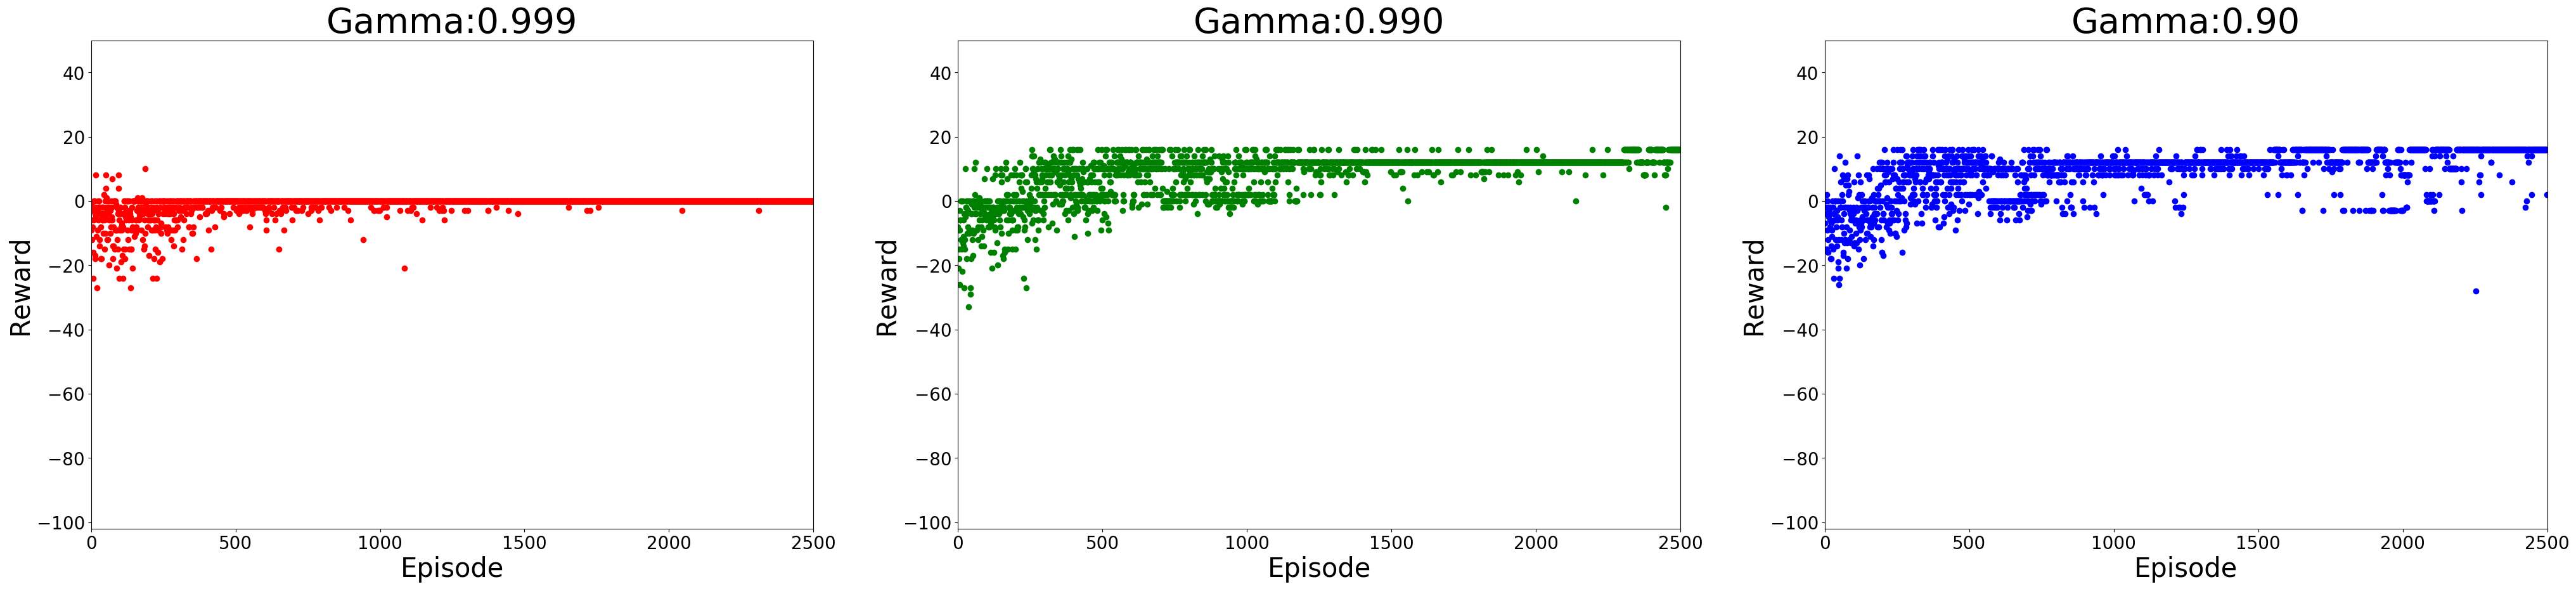

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(50)
# fig.suptitle('Gamma Tuning', size="50")
ax1.plot(rewardSD_g1, 'ro')
ax1.set_title("Gamma:0.999", size=40)
ax1.set_ylabel('Reward', fontsize = 30) 
ax1.set_xlabel('Episode', fontsize = 30)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(100)
ax1.set_xlim(xmin=0, xmax=len(rewardSD_g1))
ax1.set_ylim(ymin=-102, ymax=50)
ax2.plot(rewardSD_g2, 'go')
ax2.set_title("Gamma:0.990", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=len(rewardSD_g2))
ax2.set_ylim(ymin=-102, ymax=50)
ax3.plot(rewardSD_g3, 'bo')
ax3.set_title("Gamma:0.90", size=40)
ax3.set_ylabel('Reward', fontsize = 30) 
ax3.set_xlabel('Episode', fontsize = 30)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax3.set_xlim(xmin=0, xmax=len(rewardSD_g3))
ax3.set_ylim(ymin=-102, ymax=50)
plt.show()

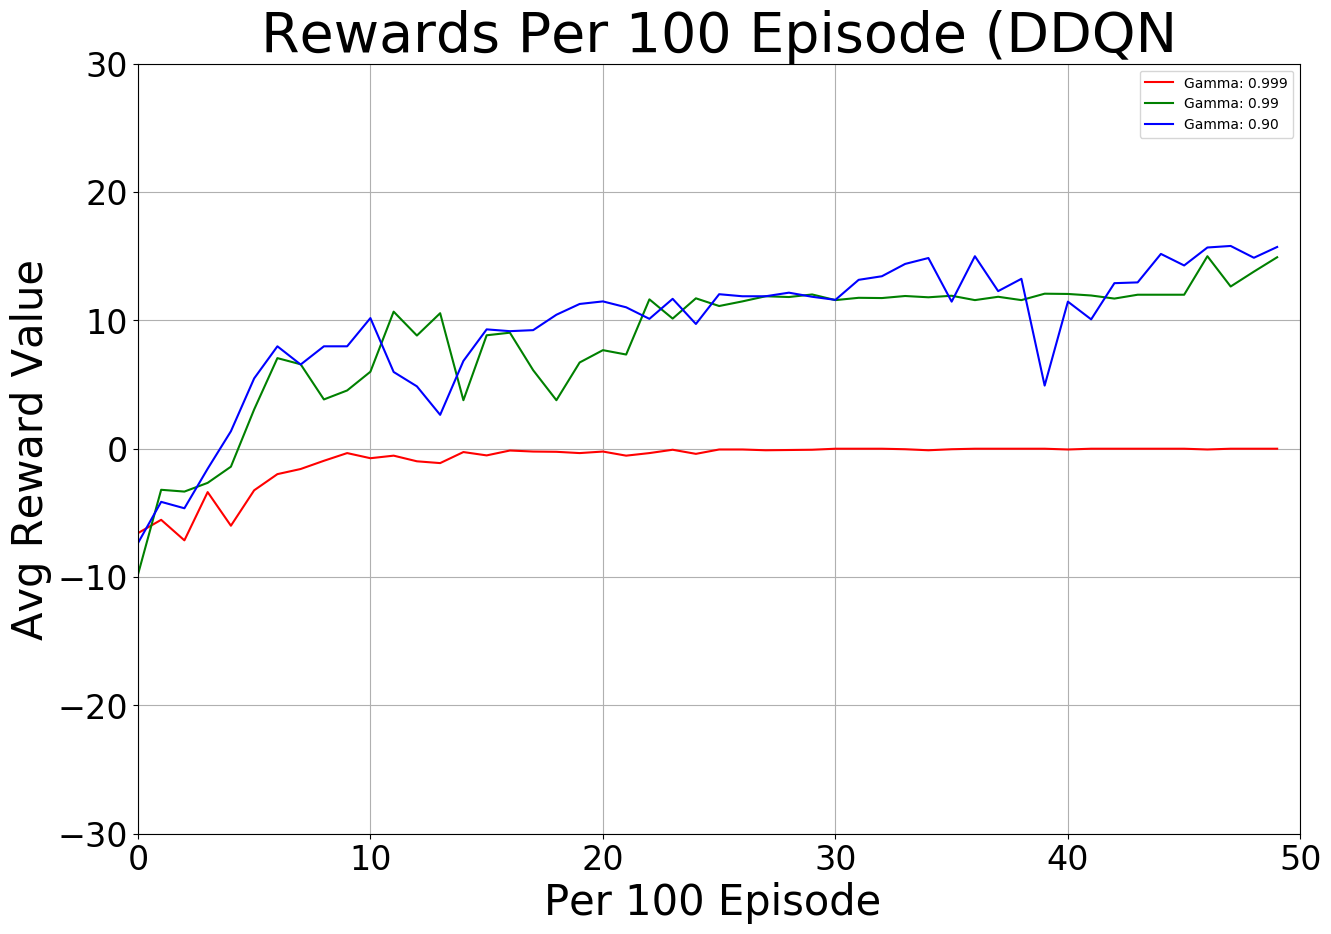

In [30]:
rewardQD_ts1_avg = []
rewardQD_ts2_avg = []
rewardQD_ts3_avg = []
for s in np.split(np.array(rewardSD_g1), 50):
    rewardQD_ts1_avg.append((sum(s)/len(s)))

for s in np.split(np.array(rewardSD_g2), 50):
    rewardQD_ts2_avg.append((sum(s)/len(s)))

for s in np.split(np.array(rewardSD_g3), 50):
    rewardQD_ts3_avg.append((sum(s)/len(s)))

plt.figure(figsize=(15, 10))
plt.plot(rewardQD_ts1_avg, 'r-')
plt.plot(rewardQD_ts2_avg, 'g-')
plt.plot(rewardQD_ts3_avg, 'b-')
plt.legend(["Gamma: 0.999", "Gamma: 0.99", "Gamma: 0.90"])
plt.xlabel('Per 100 Episode ', fontsize=30)
plt.ylabel('Avg Reward Value', fontsize=30)
plt.title('Rewards Per 100 Episode (DDQN', fontsize=40)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(ymin=-30, ymax=30)
plt.xlim(xmin=0, xmax=50)
plt.grid()
plt.show()

In [8]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
obs = env.reset()
da = GridDoubleDQN(env)
da.learn()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
  4%|▍         | 102/2500 [00:09<03:29, 11.45episodes/s]

Buffer_size: 2948|Train_time:0.002514646053314209| Sub_t:0.002885773181915283
[Episode: 100] - Steps: 29.48 | Rewards: -6.65 | Epsilon: 0.8317637711026726 | loss: 0.000


  8%|▊         | 202/2500 [00:18<03:12, 11.96episodes/s]

Buffer_size: 4000|Train_time:0.002686614990234375| Sub_t:0.0031112337112426756
[Episode: 200] - Steps: 28.09 | Rewards: -0.37 | Epsilon: 0.691830970918939 | loss: 0.000


 12%|█▏        | 301/2500 [00:26<02:58, 12.31episodes/s]

Buffer_size: 4000|Train_time:0.002601461410522461| Sub_t:0.0030310249328613283
[Episode: 300] - Steps: 25.02 | Rewards: 4.8 | Epsilon: 0.5754399373371608 | loss: 0.000


 16%|█▌        | 402/2500 [00:35<02:32, 13.76episodes/s]

Buffer_size: 4000|Train_time:0.0026218104362487793| Sub_t:0.0030620265007019042
[Episode: 400] - Steps: 25.54 | Rewards: 4.6 | Epsilon: 0.47863009232264275 | loss: 0.000


 20%|██        | 502/2500 [00:43<02:37, 12.66episodes/s]

Buffer_size: 4000|Train_time:0.0027258634567260743| Sub_t:0.003198099136352539
[Episode: 500] - Steps: 23.85 | Rewards: 6.75 | Epsilon: 0.3981071705535017 | loss: 0.000


 24%|██▍       | 603/2500 [00:49<01:54, 16.58episodes/s]

Buffer_size: 4000|Train_time:0.0026306748390197755| Sub_t:0.0030674099922180175
[Episode: 600] - Steps: 19.24 | Rewards: 8.79 | Epsilon: 0.3311311214825956 | loss: 0.000


 28%|██▊       | 701/2500 [00:56<02:16, 13.20episodes/s]

Buffer_size: 4000|Train_time:0.002599945068359375| Sub_t:0.0030951333045959473
[Episode: 700] - Steps: 20.73 | Rewards: 6.57 | Epsilon: 0.27542287033382085 | loss: 0.000


 32%|███▏      | 803/2500 [01:04<01:57, 14.41episodes/s]

Buffer_size: 4000|Train_time:0.002735559940338135| Sub_t:0.003231384754180908
[Episode: 800] - Steps: 23.3 | Rewards: 6.43 | Epsilon: 0.22908676527678132 | loss: 0.000


 36%|███▌      | 904/2500 [01:10<01:10, 22.50episodes/s]

Buffer_size: 4000|Train_time:0.0025956559181213377| Sub_t:0.003097057342529297
[Episode: 900] - Steps: 19.45 | Rewards: 7.35 | Epsilon: 0.19054607179632832 | loss: 0.000


 40%|████      | 1001/2500 [01:14<01:04, 23.23episodes/s]

Buffer_size: 4000|Train_time:0.002853202819824219| Sub_t:0.0033768248558044434
[Episode: 1000] - Steps: 12.65 | Rewards: 9.95 | Epsilon: 0.15848931924611465 | loss: 0.000


 44%|████▍     | 1105/2500 [01:18<00:51, 27.14episodes/s]

Buffer_size: 4000|Train_time:0.002689998149871826| Sub_t:0.003216698169708252
[Episode: 1100] - Steps: 11.93 | Rewards: 10.36 | Epsilon: 0.13182567385564378 | loss: 0.000


 48%|████▊     | 1205/2500 [01:22<00:59, 21.89episodes/s]

Buffer_size: 4000|Train_time:0.004678194522857666| Sub_t:0.005614924430847168
[Episode: 1200] - Steps: 11.73 | Rewards: 11.72 | Epsilon: 0.10964781961432139 | loss: 0.000


 52%|█████▏    | 1304/2500 [01:26<00:40, 29.86episodes/s]

Buffer_size: 4000|Train_time:0.0025369572639465333| Sub_t:0.0030785942077636718
[Episode: 1300] - Steps: 11.04 | Rewards: 12.61 | Epsilon: 0.09120108393559365 | loss: 0.000


 56%|█████▌    | 1405/2500 [01:30<00:38, 28.08episodes/s]

Buffer_size: 4000|Train_time:0.002653515338897705| Sub_t:0.003265690803527832
[Episode: 1400] - Steps: 10.71 | Rewards: 14.62 | Epsilon: 0.07585775750292077 | loss: 0.000


 60%|██████    | 1505/2500 [01:34<00:34, 28.51episodes/s]

Buffer_size: 4000|Train_time:0.0026388311386108397| Sub_t:0.003236987590789795
[Episode: 1500] - Steps: 10.96 | Rewards: 14.59 | Epsilon: 0.06309573444802141 | loss: 0.000


 64%|██████▍   | 1604/2500 [01:37<00:31, 28.49episodes/s]

Buffer_size: 4000|Train_time:0.0026142120361328123| Sub_t:0.0031187939643859863
[Episode: 1600] - Steps: 10.53 | Rewards: 15.66 | Epsilon: 0.052480746024979104 | loss: 0.000


 68%|██████▊   | 1705/2500 [01:41<00:35, 22.55episodes/s]

Buffer_size: 4000|Train_time:0.004770762920379638| Sub_t:0.005527667999267578
[Episode: 1700] - Steps: 10.37 | Rewards: 15.76 | Epsilon: 0.043651583224018214 | loss: 0.000


 72%|███████▏  | 1806/2500 [01:44<00:22, 30.20episodes/s]

Buffer_size: 4000|Train_time:0.0025580668449401854| Sub_t:0.0031071090698242187
[Episode: 1800] - Steps: 10.31 | Rewards: 15.6 | Epsilon: 0.03630780547701154 | loss: 0.000


 76%|███████▌  | 1904/2500 [01:48<00:22, 26.48episodes/s]

Buffer_size: 4000|Train_time:0.0025902462005615236| Sub_t:0.0031202149391174314
[Episode: 1900] - Steps: 10.38 | Rewards: 15.66 | Epsilon: 0.030199517204021385 | loss: 0.000


 80%|████████  | 2006/2500 [01:51<00:21, 23.37episodes/s]

Buffer_size: 4000|Train_time:0.004781825542449951| Sub_t:0.005667636394500733
[Episode: 2000] - Steps: 10.34 | Rewards: 15.4 | Epsilon: 0.025118864315096866 | loss: 0.000


 84%|████████▍ | 2106/2500 [01:55<00:12, 31.52episodes/s]

Buffer_size: 4000|Train_time:0.002530369758605957| Sub_t:0.0030732131004333496
[Episode: 2100] - Steps: 10.29 | Rewards: 15.6 | Epsilon: 0.02089296130854132 | loss: 0.000


 88%|████████▊ | 2205/2500 [01:58<00:09, 30.53episodes/s]

Buffer_size: 4000|Train_time:0.0026027059555053713| Sub_t:0.0031206655502319337
[Episode: 2200] - Steps: 10.14 | Rewards: 15.84 | Epsilon: 0.017378008287494567 | loss: 0.000


 92%|█████████▏| 2305/2500 [02:02<00:07, 25.17episodes/s]

Buffer_size: 4000|Train_time:0.004212093353271484| Sub_t:0.005277309417724609
[Episode: 2300] - Steps: 10.08 | Rewards: 15.92 | Epsilon: 0.014454397707459973 | loss: 0.000


 96%|█████████▌| 2404/2500 [02:05<00:03, 28.51episodes/s]

Buffer_size: 4000|Train_time:0.0027093076705932617| Sub_t:0.0032522392272949217
[Episode: 2400] - Steps: 10.13 | Rewards: 16.0 | Epsilon: 0.012022644346174735 | loss: 0.000


100%|██████████| 2500/2500 [02:09<00:00, 19.37episodes/s]

Buffer_size: 4000|Train_time:0.0025391507148742674| Sub_t:0.0030497622489929197
[Episode: 2500] - Steps: 10.07 | Rewards: 15.97 | Epsilon: 0.01000000000000053 | loss: 0.000


In [9]:
epsilon_list_train_dqn = da.epsilon_list
reward_list_train_dqn = da.rewards_list

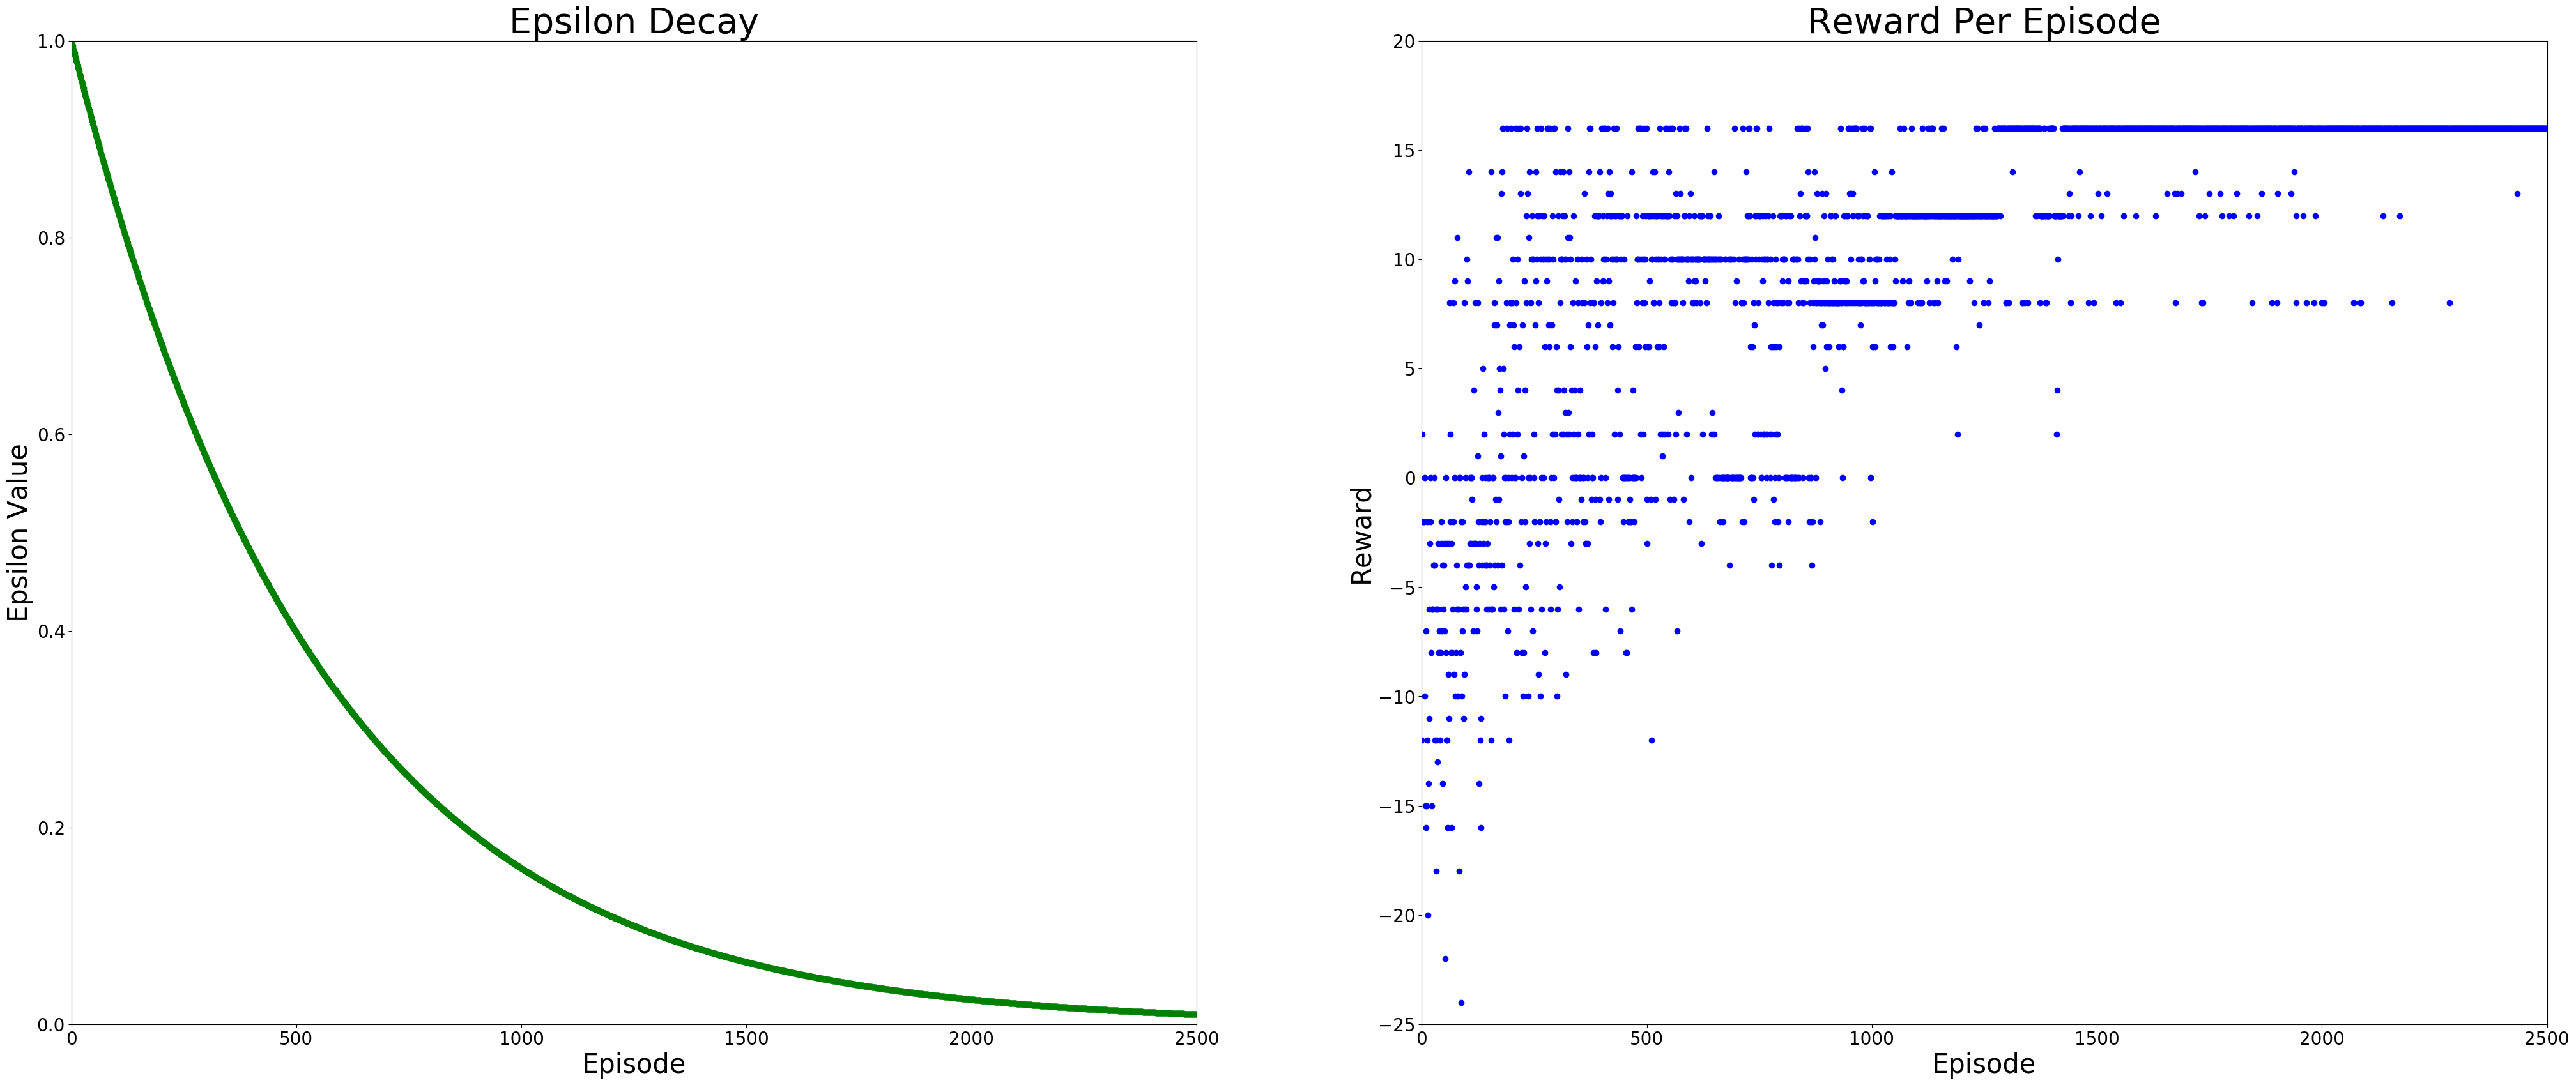

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(20)
fig.set_figwidth(50)
# fig.suptitle('Gamma Tuning', size="50")
ax1.plot(epsilon_list_train_dqn, 'go')
ax1.set_title("Epsilon Decay", size=40)
ax1.set_ylabel('Epsilon Value', fontsize = 30) 
ax1.set_xlabel('Episode', fontsize = 30)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(100)
ax1.set_xlim(xmin=0, xmax=da.max_episodes)
ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_train_dqn, 'bo')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=da.max_episodes)
ax2.set_ylim(ymin=-25, ymax=20)
plt.show()

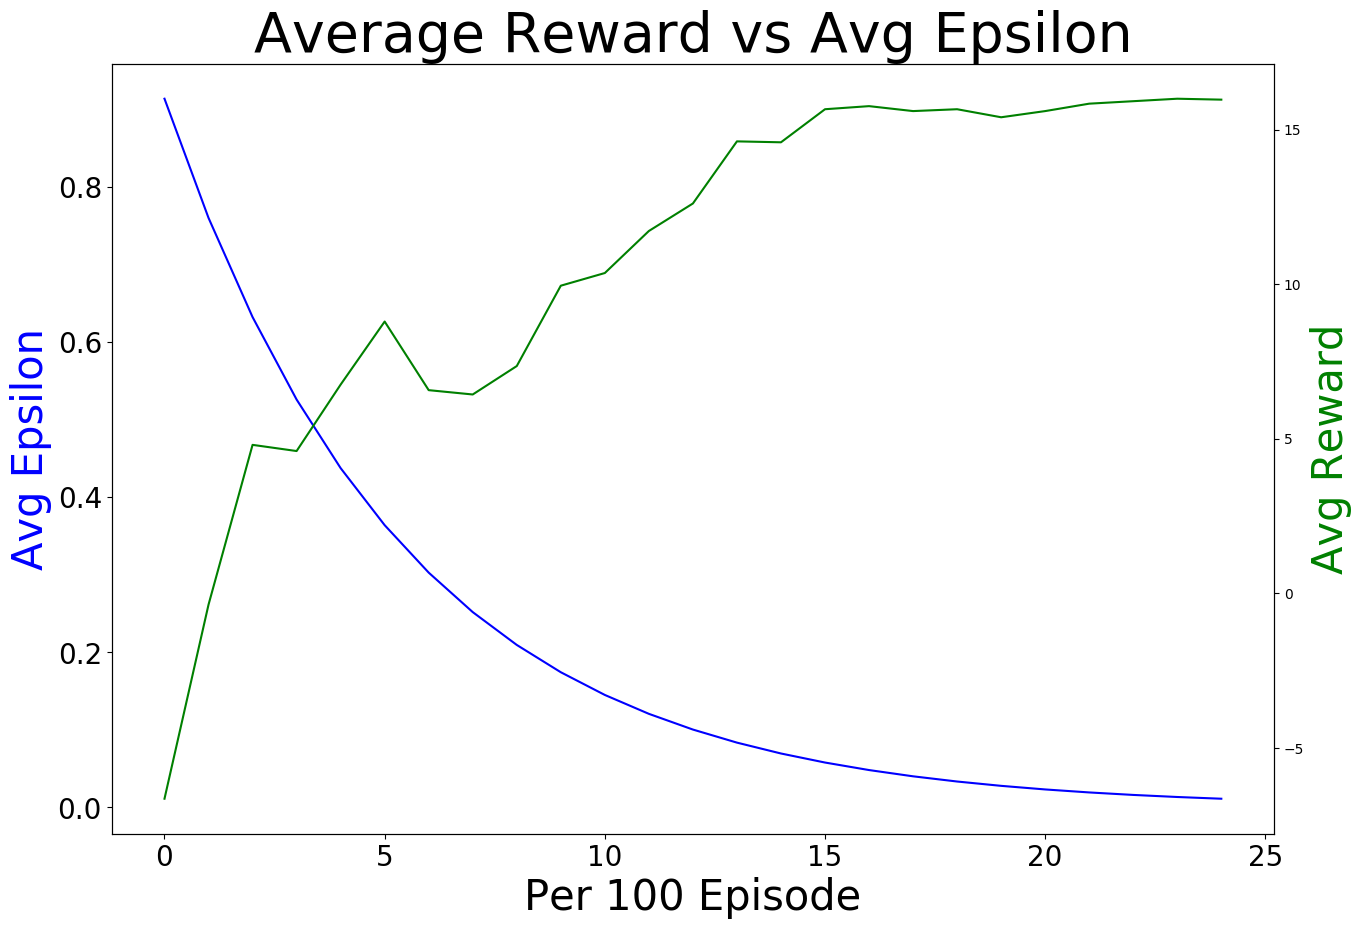

In [12]:
rewardSD_train_dqn_avg = []
for s in np.split(np.array(reward_list_train_dqn), 25):
    rewardSD_train_dqn_avg.append((sum(s)/len(s)))
    
epsilonSD_train_dqn_avg = []
for s in np.split(np.array(epsilon_list_train_dqn), 25):
    epsilonSD_train_dqn_avg.append((sum(s)/len(s)))

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2 = ax1.twinx()
ax1.plot(epsilonSD_train_dqn_avg, 'b-')
ax2.plot(rewardSD_train_dqn_avg, 'g-')
ax1.set_title("Average Reward vs Avg Epsilon", size=40)
ax1.set_xlabel('Per 100 Episode', fontsize=30)
ax1.set_ylabel('Avg Epsilon', color='b', fontsize=30)
ax2.set_ylabel('Avg Reward', color='g', fontsize=30)
plt.show()

In [13]:
import json
with open('reward_ddqn.json', 'w') as f:
    json.dump(reward_list_train_dqn, f)

In [14]:
PATH = './grid.pth'
torch.save(da.q_value_dqn.state_dict(), PATH)

In [19]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
env.reset()
da = GridDoubleDQN(env)
da.eval(load=True)

100%|██████████| 10/10 [00:00<00:00, 156.34episodes/s]


In [13]:
reward_list_test_dqn = da.test_rewards_list

<Figure size 640x480 with 0 Axes>

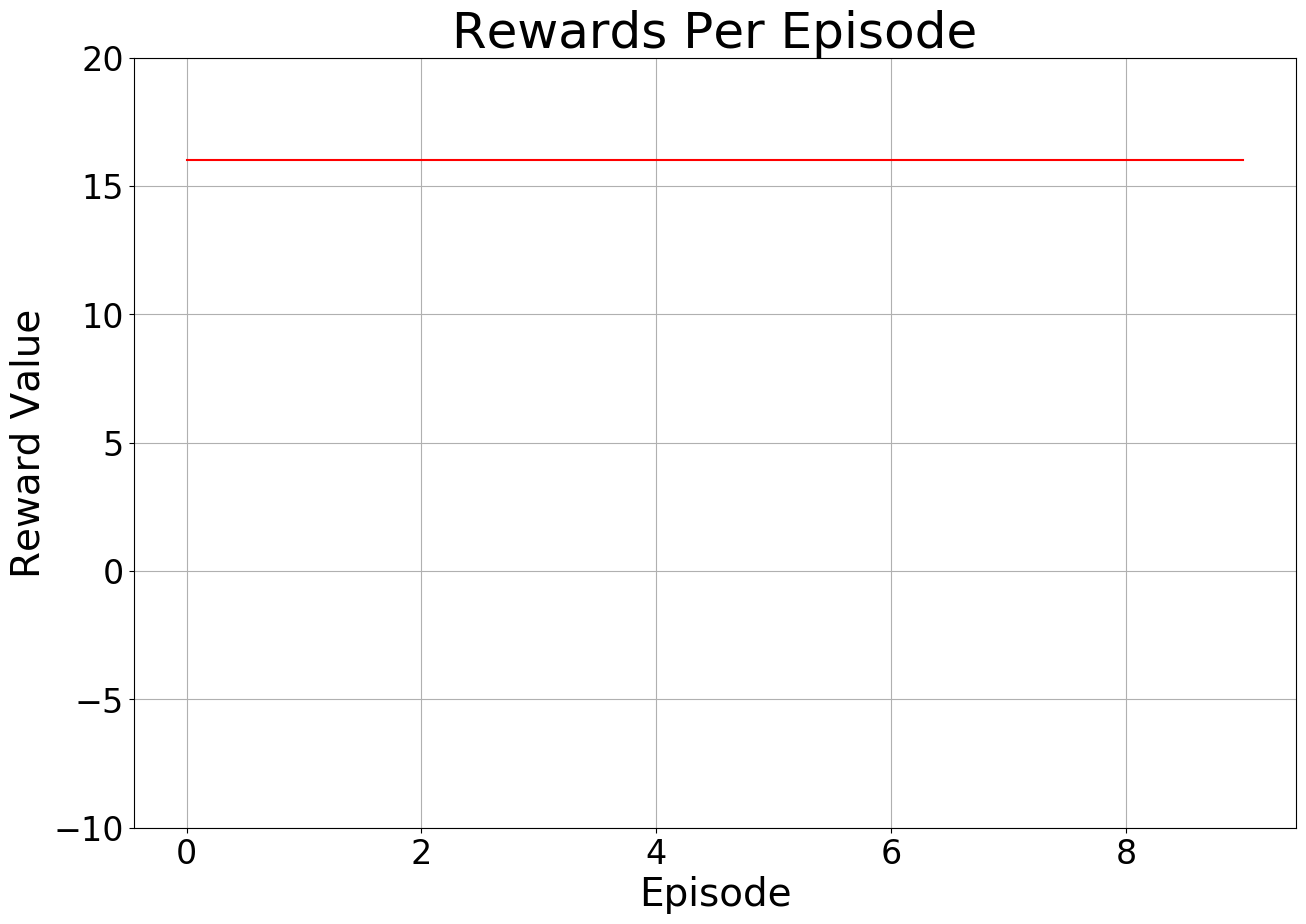

In [17]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(reward_list_test_dqn, 'r-')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title(f'Rewards Per Episode', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-10, ymax=20)
# plt.xlim(xmin=0, xmax=self.max_episodes_test)
plt.grid()
plt.show()